# **Analyzing Land Surface Temperature and Uncertainties: Insights from ESA CCI Data**

This notebook guides you through analyzing Land Surface Temperature (LST) data from the ESA Climate Change Initiative (CCI) to study urban heat islands, focusing on the Leicestershire region. We’ll use LST data alongside land cover information to identify temperature differences between urban and non-urban areas. Additionally, we’ll discuss uncertainties associated with LST data products.

## Objectives
- Access and visualize LST data for Leicestershire using the ESA CCI toolbox.
- Analyze urban heat islands in Leicestershire by comparing urban and non-urban areas.
- Explore uncertainties in LST data and interpret quality flags.

### Add imports
To run this Notebook, make sure the ESA CCI Toolbox is setup correctly.

In [33]:
from xcube.core.store import new_data_store
import IPython.display
import shapely.geometry
import matplotlib.pyplot as plt
from esa_climate_toolbox.core import get_store
from esa_climate_toolbox.core import get_op
from esa_climate_toolbox.core import list_ecv_datasets
from esa_climate_toolbox.core import list_datasets
from esa_climate_toolbox.ops import downsample_2d
from esa_climate_toolbox.ops import coregister
import matplotlib
import numpy as np
import xarray as xr

# 1. Access and visualize LST data
In this section, we explore how to access Land Surface Temperature (LST) data from the ESA Climate Change Initiative (CCI) data store. This includes identifying datasets of interest, understanding their metadata, and preparing for subsequent analysis.

The ESA CCI provides high-quality, harmonized climate data records that are essential for monitoring and understanding climate variability and trends. These datasets are generated using consistent algorithms across space and time, ensuring their reliability for climate research and applications.

### Filter and Select LST Data
Identify LST datasets based on spatial and temporal requirements. The `list_ecv_datasets` command returns the names of datasets for a given essential climate variable.

In [34]:
list_ecv_datasets("LST")

[('esacci.LST.3-hours.L3S.LST.multi-sensor.multi-platform.IRMGP.1-00.r1',
  'esa-cci'),
 ('esacci.LST.day.L3C.LST.AATSR.Envisat.ATSR_3.3-00.DAY', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.AATSR.Envisat.ATSR_3.3-00.NIGHT', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.ATSR-2.ERS-2.ATSR_2.3-00.DAY', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.ATSR-2.ERS-2.ATSR_2.3-00.NIGHT', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.MODIS.Aqua.MODISA.3-00.DAY', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.MODIS.Aqua.MODISA.3-00.NIGHT', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.MODIS.Terra.MODIST.3-00.DAY', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.MODIS.Terra.MODIST.3-00.NIGHT', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.SLSTR.Sentinel-3A.SLSTRA.3-00.DAY', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.SLSTR.Sentinel-3A.SLSTRA.3-00.NIGHT', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.SLSTR.Sentinel-3B.SLSTRB.3-00.DAY', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.SLSTR.Sentinel-3B.SLSTRB.3-00.NIGHT', 'esa-cci'),
 ('esacci.LST.day.L3C.LST.multi-sensor.multi-platform.SS

### zarr & kerchunk & NetCDF format
For this workshop it might be a good idea to use LST data in zarr or kerchunk format, as data loading will be much faster.
Several CCI data records are available in these formats as they have some advantages. 
Zarr is ideal for new datasets that will be frequently accessed, updated, or analyzed and it is suitable for large-scale distributed processing in cloud-native workflows.
Kerchunk is best for efficiently accessing legacy data formats (e.g., NetCDF, GRIB) stored in object stores without converting them and useful when data duplication must be avoided.
NetCDF, while widely used and highly compatible with scientific tools, is less optimized for cloud-native workflows and accessing large datasets efficiently, making it better suited for smaller-scale, traditional file-based analysis.

| **Feature**                     | **Zarr**                               | **Kerchunk**                          | **NetCDF**                            |
|----------------------------------|----------------------------------------|---------------------------------------|---------------------------------------|
| **Storage Format**               | Self-contained, new format             | Wrapper for existing formats          | Traditional file-based format         |
| **Cloud-Native**                 | Yes                                    | Yes                                   | No                                    |
| **Efficiency**                   | Good for accessing subsets             | Great for legacy data in object stores| Efficient for small to medium files   |
| **Compression**                  | Supports multiple algorithms           | Depends on underlying format          | Limited to format-specific methods    |
| **Metadata Handling**            | Embedded metadata                      | External JSON index                   | Embedded in file                      |
| **Read/Write Access**            | Supports both                          | Read-only                             | Read and write                        |
| **Setup Overhead**               | None, works out of the box             | Requires pre-generated JSON indices   | None, but slower for large datasets   |
| **Storage Duplication**          | Requires duplicating data              | Minimal, uses existing files          | Minimal, as data is stored in single files |
| **Performance**                  | Optimized for chunk-based access       | Slight overhead for index lookup      | Can be slow for very large files      |


In [35]:
list_datasets("esa-cci-zarr")

['ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-OCO-2-FOCAL-2014-2021-v10.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2020-fv2.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_DAY-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_NIGHT-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_DAY-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_NIGHT-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01de

### Defining the Region of Interest (Leicestershire)

In this section, we define the bounding box for the Leicestershire region to extract a dataset sample covering both urban and non-urban areas. This will help to analyze temperature variations between these areas. In addition, the data size to download will be much smaller.

In [36]:
# Set bounding box for Leicestershire
lon_min, lon_max = -1.5, -0.5
lat_min, lat_max = 52.5, 53.5

bbox = (lon_min, lat_min, lon_max, lat_max)

# Display bounding box for reference
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

### LST data basing on polar-orbiting satellites
For this example, we will have a look at monthly LST for the years 2011 to 2020, which is available in the zarr data store:
'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1MONTHLY_DAY-1995-2020-fv3.00.zarr'

This dataset provides monthly-averaged land surface temperatures (LSTs) and uncertainty estimates from multiple polar-orbiting satellites, spanning August 1995 to December 2020, with coverage on a 0.01° global grid. LSTs, derived from instruments such as ATSR-2, AATSR, MODIS Terra, and SLSTR, are adjusted for inter-instrument biases and provide separate daytime (used in this example) and nighttime temperatures along with observation geometry, land cover, and quality flags. Produced by the University of Leicester as part of the ESA Land Surface Temperature Climate Change Initiative, the dataset meets GCOS standards and supports studies of surface heat and water fluxes.

In [37]:
cci_zarr_store = get_store("esa-cci-zarr")
lst_ds = cci_zarr_store.open_data(
    'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1MONTHLY_DAY-1995-2020-fv3.00.zarr'
)
lst_ds

<xarray.Dataset> Size: 18TB
Dimensions:          (channel: 2, time: 294, lat: 18000, lon: 36000,
                      length_scale: 294)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 72kB -90.0 -89.99 -89.98 ... 89.98 89.99
  * lon              (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time             (time) datetime64[ns] 2kB 1995-08-01 ... 2020-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lcc              (time, lat, lon) float32 762GB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst              (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    n                (time, lat, lon) float32 762GB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    sataz            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    satze            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    solaz            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    solze            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3S global land surf...
    time_coverage_duration:     P1M
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1M
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature time ser...

Now get a spatial and temporal subset. This reduces the data size and speeds up calculations.

In [38]:
subset_spatial_op = get_op('subset_spatial')
lst_ds_sub = subset_spatial_op(ds=lst_ds, region=bbox)

In [39]:
subset_temporal_op = get_op('subset_temporal')
lst_ds_sub = subset_temporal_op(ds=lst_ds_sub, time_range=['2011-01-01', '2020-12-01'])
lst_ds_sub  # use this to have a quick look into the metadata

<xarray.Dataset> Size: 116MB
Dimensions:          (channel: 2, time: 120, lat: 101, lon: 100,
                      length_scale: 294)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 404B 52.51 52.51 52.53 ... 53.48 53.49 53.51
  * lon              (lon) float32 400B -1.495 -1.485 -1.475 ... -0.515 -0.505
  * time             (time) datetime64[ns] 960B 2011-01-01 ... 2020-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    lcc              (time, lat, lon) float32 5MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    lst              (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    n                (time, lat, lon) float32 5MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    sataz            (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    satze            (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    solaz            (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
    solze            (time, lat, lon) float64 10MB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    time_coverage_end:          2020-12-01T00:00:00
    time_coverage_resolution:   P1M
    time_coverage_start:        2011-01-01T00:00:00
    title:                      ESA LST CCI land surface temperature time ser...
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-1.4999972581863403 52.5000038146972...

To get an impression of the mean LST in that region, we calculate the mean of the data and make a simple plot. The `climatology` operation of the CCI Toolbox creates a ‘mean over years’ dataset by averaging the values of the given input dataset over all years. The output is a climatological dataset with the same resolution as the input dataset, in this example a monthly climatology.

In [40]:
climatology_op = get_op('climatology')
lst_ds_clim = climatology_op(ds=lst_ds_sub)
# lst_ds_clim  # use this to have a quick look into the metadata

# The warning is informing you that the code is handling np.datetime64 objects without explicit timezone information. 
# This is typically not a problem for operations that do not require timezone awareness, such as climatology calculations, 
# but it might lead to unexpected behavior if timezone handling is critical for your workflow.

/cmsaf/cmsaf-ops3/stkothe/KE/ect/lib/python3.12/site-packages/esa_climate_toolbox/ops/aggregate.py:134: UserWarning: no explicit representation of timezones available for np.datetime64
  climatology_bounds = xr.DataArray(data=da.tile(np.array([time_min, time_max],


### Let's plot the climatology data
1. Plotting LST Data: The code uses the plot_op operation to create a plot of mean Land Surface Temperature (LST) for a specific date (2011-06-01 represents the mean for June 2011 to 2020) from the dataset lst_ds_clim, applying a color map ('viridis') and adding a title for context.
2. Adding Geographical Markers: The plot highlights specific locations, Leicester and Nottingham, by overlaying markers (o) with dashed lines at their respective latitude and longitude coordinates.
3. Customizing the Plot: Legends are added to label the geographical markers, enhancing the plot’s interpretability for spatial analysis.

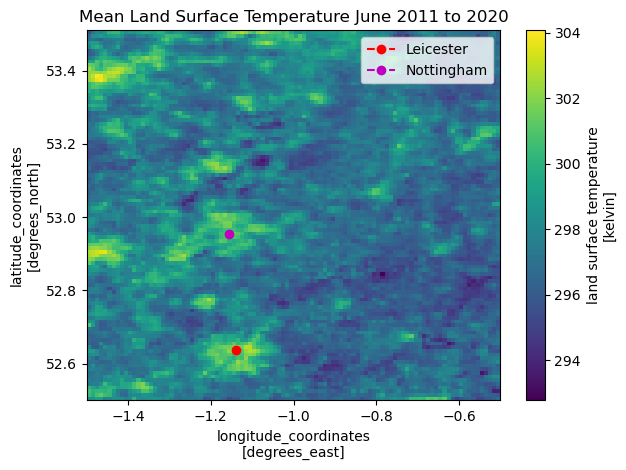

In [41]:
plot_op = get_op('plot')
# Create a plot of the LST data
%matplotlib inline 

plot_op(
    ds=lst_ds_clim,  # Dataset variable
    var='lst',       # Variable you want to plot
    indexers={'time': '2011-06-01'},  # Specify the date
    title="Mean Land Surface Temperature June 2011 to 2020",
    properties="cmap='viridis'",  # Pass other properties here, such as color
)

# Add Leicester to the plot
leicester_lat, leicester_lon = 52.6369, -1.1398
plt.plot(leicester_lon, leicester_lat, linestyle='--', marker='o', color='r', label='Leicester')
plt.legend()

# Add Nottingham to the plot
nottingham_lat, nottingham_lon = 52.9536, -1.1569
plt.plot(nottingham_lon, nottingham_lat, linestyle='--', marker='o', color='m', label='Nottingham')
plt.legend()



# 2. Analyze urban heat islands

Urban areas often exhibit higher temperatures compared to their surrounding non-urban regions, a phenomenon known as the **Urban Heat Island (UHI) effect**. This section focuses on quantifying and visualizing this effect using Land Surface Temperature (LST) data from the ESA CCI dataset. By comparing LST values in urban and non-urban pixels, we can identify temperature differences and analyze their spatial patterns over time. This analysis is particularly relevant for understanding the impacts of urbanization on local climates and informing sustainable urban planning.

### Land Cover (LC) data
For this step, we will use LC data for the same region. The ESA Land Cover CCI provides annual global land cover maps at 300m spatial resolution, covering the period from 1992 to 2015. Each pixel represents a land cover class based on the UN Land Cover Classification System (LCCS), accompanied by quality flags that document the classification reliability. These data offer a valuable resource for studying land cover dynamics and their role in climate systems.

In [42]:
lc_ds = cci_zarr_store.open_data(
    'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr'
)
lc_ds

<xarray.Dataset> Size: 4TB
Dimensions:              (time: 24, lat: 64800, lon: 129600)
Coordinates:
  * lat                  (lat) float32 259kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float32 518kB -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 192B 1992-07-02 ... 2015-07-03
Data variables:
    change_count         (time, lat, lon) float32 806GB dask.array<chunksize=(1, 2592, 1296), meta=np.ndarray>
    current_pixel_state  (time, lat, lon) float32 806GB dask.array<chunksize=(1, 2592, 1296), meta=np.ndarray>
    lccs_class           (time, lat, lon) float32 806GB dask.array<chunksize=(1, 2592, 1296), meta=np.ndarray>
    observation_count    (time, lat, lon) float32 806GB dask.array<chunksize=(1, 2592, 1296), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 806GB dask.array<chunksize=(1, 2592, 1296), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.6
    TileSize:                   2048:2048
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/b382ebe6679...
    cdm_data_type:              grid
    comment:                    
    contact:                    landcover-cci@uclouvain.be
    ...                         ...
    time_coverage_end:          20150703T000000Z
    time_coverage_resolution:   P1Y
    time_coverage_start:        20150703T000000Z
    title:                      ESA CCI Land Cover Map
    tracking_id:                12590bad-9014-4a91-9048-d06b67965490
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

In [43]:
lc_ds_sub = subset_temporal_op(ds=lc_ds, time_range=['2015-07-03', '2015-07-03'])

In [44]:
select_var_op = get_op('select_var')
lc_ds_sub = select_var_op(ds=lc_ds_sub, var="lccs_class")

### Downsample LC data to match the grid resolution of LST data 
This code snippet first normalizes the land cover dataset (`lc_ds_sub`) to standardize its values using the `normalize_op` operation. It then coregisters the normalized land cover dataset (`lc_ds_sub`) with the land surface temperature dataset (`lst_ds_sub`) using the `coregister_op` operation, aligning their spatial grids and downsampling the land cover data to match the LST grid using the "mode" method for categorical data.

Resampling categorical data presents a challenge because traditional statistical methods like averaging are not suitable. Instead, mode-based aggregation must be used to preserve the integrity of categorical classifications, ensuring that the dominant class in each new grid cell accurately reflects the underlying data.

In [45]:
normalize_op = get_op('normalize')

lc_ds_sub = normalize_op(ds=lc_ds_sub)

coregister_op = get_op('coregister')

downsampled_lc = coregister_op(
    ds_primary=lst_ds_sub,
    ds_replica=lc_ds_sub,
    method_ds="mode"
)
downsampled_lc

<xarray.Dataset> Size: 41kB
Dimensions:     (lat: 101, lon: 100, time: 1)
Coordinates:
  * lat         (lat) float32 404B 52.51 52.51 52.53 52.53 ... 53.48 53.49 53.51
  * lon         (lon) float32 400B -1.495 -1.485 -1.475 ... -0.525 -0.515 -0.505
  * time        (time) datetime64[ns] 8B 2015-07-03
Data variables:
    lccs_class  (time, lat, lon) float32 40kB dask.array<chunksize=(1, 101, 100), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.6
    TileSize:                   2048:2048
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/b382ebe6679...
    cdm_data_type:              grid
    comment:                    
    contact:                    landcover-cci@uclouvain.be
    ...                         ...
    time_coverage_start:        2015-07-03T00:00:00
    title:                      ESA CCI Land Cover Map
    tracking_id:                12590bad-9014-4a91-9048-d06b67965490
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-1.4999972581863403 52.5000038146972...

Plotting the resulting LC field. You can have a look into the metadata of the `lccs_class` variable to get the meaning of each land cover flag.

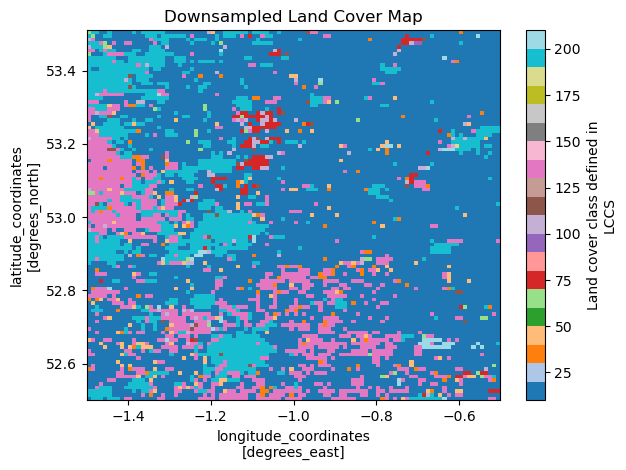

In [46]:
# Create a colormap for land cover categories (e.g., forest, urban, water)

plot_op(
    ds=downsampled_lc,           # Dataset variable (should be xarray.Dataset or DataArray)
    var='lccs_class',            # Variable name
    title="Downsampled Land Cover Map",
    properties="cmap='tab20'"    # Choose a colormap suitable for categorical data
)

### Identify urban and non-urban grid points
Information on the flag for urban grid points is stored in the meta data for the variable lccs_class of the LC data. To check if the masks for urban and non-urban grid points look reasonable, we plot both fields. 

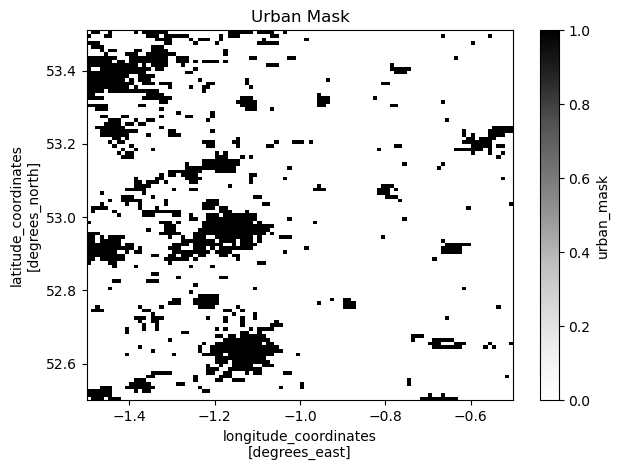

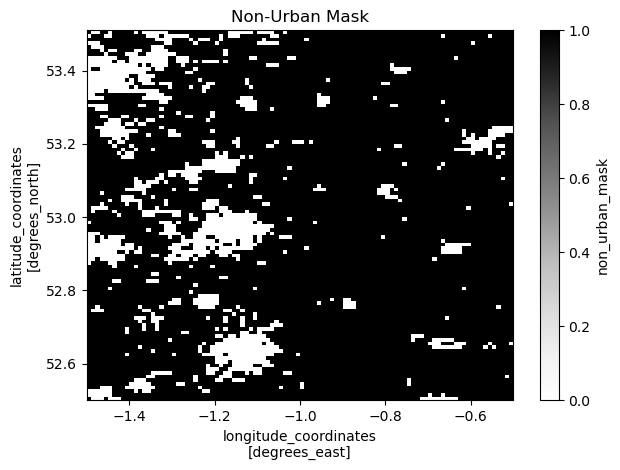

In [47]:
# Urban flag value based on the land cover data
urban_flag = 190

# Apply the threshold to create the urban mask
urban_mask = downsampled_lc['lccs_class'] >= urban_flag  # Boolean mask for urban points
urban_mask_da = urban_mask.astype(int).to_dataset(name="urban_mask")  # Convert to dataset with int values

# Plot the urban mask
plot_op(
    ds=urban_mask_da,          # Dataset variable
    var='urban_mask',          # Variable name
    title="Urban Mask",
    properties="cmap='Greys'"  # Use a greyscale colormap
)

# Apply the threshold to create the non-urban mask
non_urban_mask = ~urban_mask  # Invert the urban mask
non_urban_mask_da = non_urban_mask.astype(int).to_dataset(name="non_urban_mask")  # Convert to dataset with int values

# Plot the non-urban mask
plot_op(
    ds=non_urban_mask_da,      # Dataset variable
    var='non_urban_mask',      # Variable name
    title="Non-Urban Mask",
    properties="cmap='Greys'"  # Use a greyscale colormap
)


Now we apply this mask to the data.

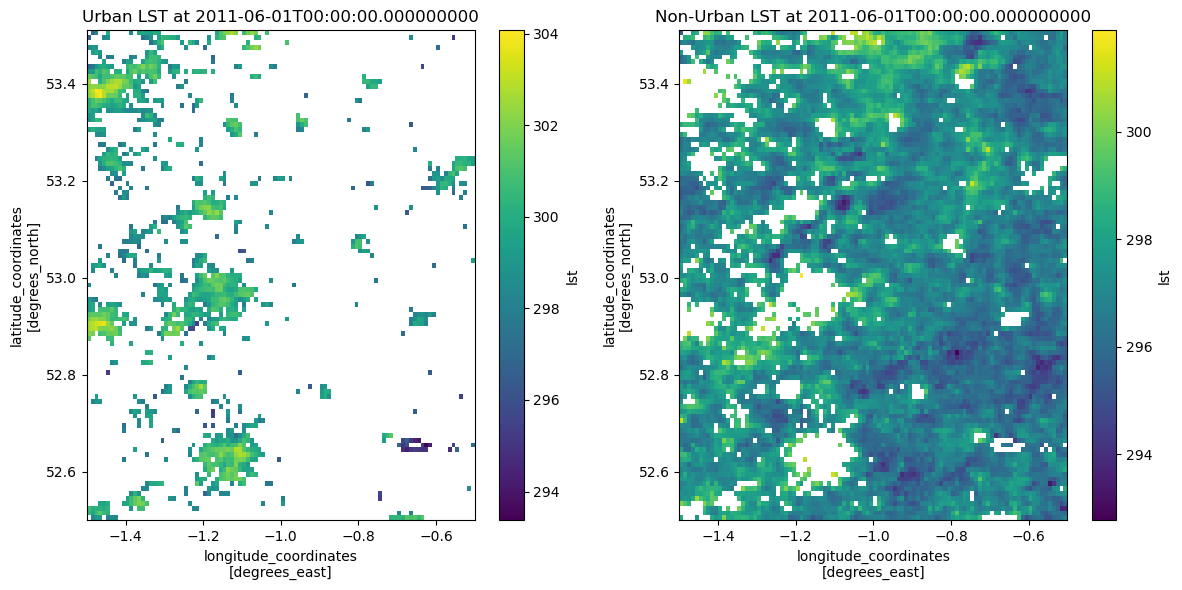

In [48]:
# Extract the LST variable as an xarray.DataArray
lst_data_array = lst_ds_clim['lst']  # Replace 'lst' with the correct variable name

# Flip the urban_mask along the latitude axis
urban_mask_flipped = np.flipud(urban_mask)  # Flip along the vertical axis

# Apply the flipped mask to the LST data
urban_lst = xr.where(urban_mask_flipped, lst_data_array, np.nan)
non_urban_lst = xr.where(~urban_mask_flipped, lst_data_array, np.nan)

# Plot an example time step
time_step = lst_data_array.time[5]  # Choose the sixth time step for June
plt.figure(figsize=(12, 6))

# Plot Urban LST
plt.subplot(1, 2, 1)
urban_lst.sel(time=time_step).plot(cmap="viridis")
plt.title(f"Urban LST at {time_step.values}")

# Plot Non-Urban LST
plt.subplot(1, 2, 2)
non_urban_lst.sel(time=time_step).plot(cmap="viridis")
plt.title(f"Non-Urban LST at {time_step.values}")

plt.tight_layout()
plt.show()



### Compare urban and non-urban grid points
When comparing urban and non-urban mean LST time series, keep in mind that the differing number of grid points can bias results. Urban areas often cover fewer, geographically clustered points, while non-urban areas span diverse climates, potentially skewing averages. Thus, we should consider including uncertainty bounds, noting the grid point counts, and normalizing results to improve comparability.

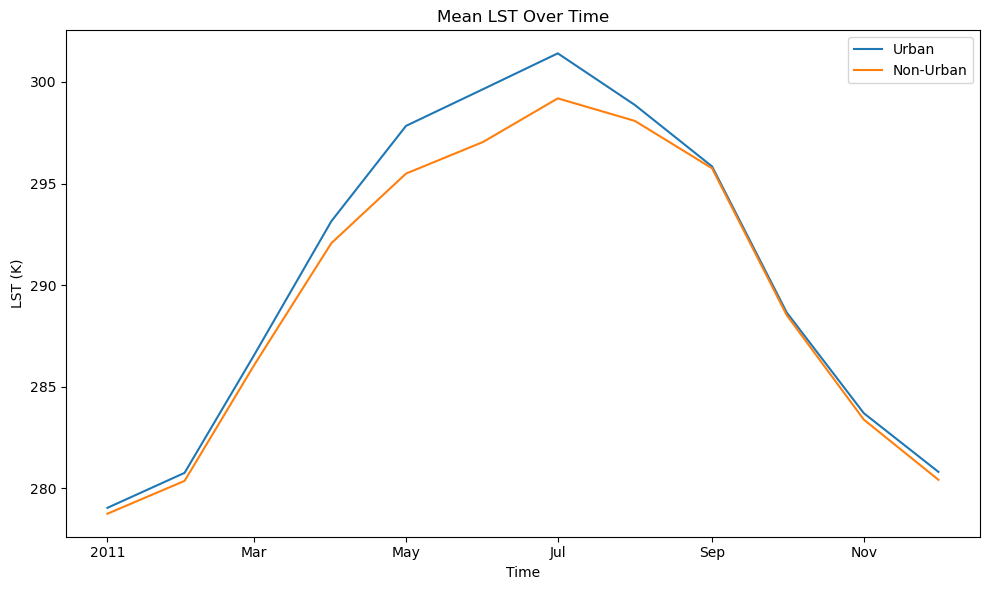

Number of Urban Grid Points: 1331
Number of Non-Urban Grid Points: 8769


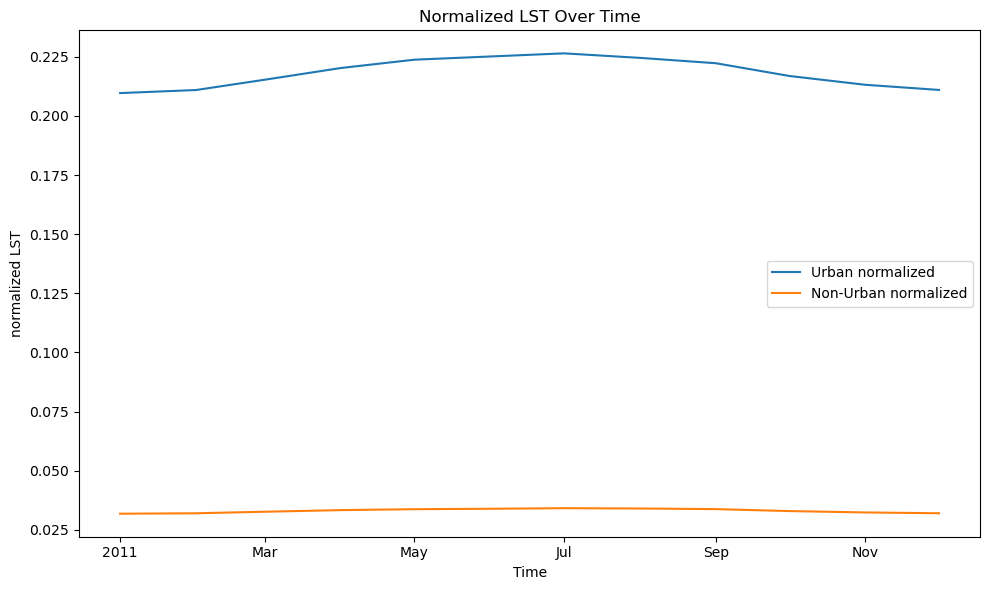

In [50]:
# Compute the mean LST for urban and non-urban pixels over time
urban_mean = urban_lst.mean(dim=["lat", "lon"])
non_urban_mean = non_urban_lst.mean(dim=["lat", "lon"])

# Plot the time series
plt.figure(figsize=(10, 6))
urban_mean.plot(label="Urban")
non_urban_mean.plot(label="Non-Urban")
plt.title("Mean LST Over Time")
plt.ylabel("LST (K)")
plt.xlabel("Time")
plt.legend()
plt.show()

# Compute the number of grid points explicitly
urban_count = urban_mask.sum().compute()  # Trigger computation for the Dask array
non_urban_count = non_urban_mask.sum().compute()

# Print the results
print(f"Number of Urban Grid Points: {urban_count.values}")
print(f"Number of Non-Urban Grid Points: {non_urban_count.values}")

normalized_urban_mean = urban_mean / urban_count
normalized_non_urban_mean = non_urban_mean / non_urban_count

# Plot the normalized time series
plt.figure(figsize=(10, 6))
normalized_urban_mean.plot(label="Urban normalized")
normalized_non_urban_mean.plot(label="Non-Urban normalized")
plt.title("Normalized LST Over Time")
plt.ylabel("normalized LST")
plt.xlabel("Time")
plt.legend()
plt.show()

# 3. Explore uncertainties
### Discussion on Uncertainties in LST Data
Land Surface Temperature (LST) data from the ESA CCI include detailed uncertainty estimates to account for the challenges of measuring surface temperatures from space. These uncertainties arise from factors such as sensor differences, atmospheric corrections, and surface characteristics, all of which can impact data quality. In this section, we explore the different sources of uncertainty, visualize their spatial and temporal distributions, and discuss how they contribute to the total uncertainty provided with the LST products. Understanding these uncertainties is essential for interpreting the data and ensuring confidence in its applications.


Let's use as an example the LST data for one random year.

In [51]:
lst_example = subset_temporal_op(ds=lst_ds_sub, time_range=['2011-01-01', '2011-12-01'])

### Step 1: Visualize Total Uncertainty
The **total uncertainty** in the CCI LST data represents the overall error estimate associated with each LST measurement. It combines contributions from multiple sources of uncertainty, including:
1. **Random Errors**:
   - Noise in the sensor measurements and other uncorrelated sources of error.
2. **Locally Correlated Errors**:
   - Errors linked to specific spatial and temporal conditions, such as:
     - **Atmospheric Scale Errors**: Uncertainty from atmospheric corrections.
     - **Surface Scale Errors**: Uncertainty due to surface emissivity and heterogeneity.
     - **LST Correction Errors**: Errors introduced during LST algorithm corrections.
3. **Systematic Errors**:
   - Larger-scale, persistent biases across the dataset, such as calibration differences between sensors or long-term trends in instrument performance.

By aggregating these components, the total uncertainty provides a comprehensive error estimate for each pixel, helping users to assess the reliability of the data for their specific applications.

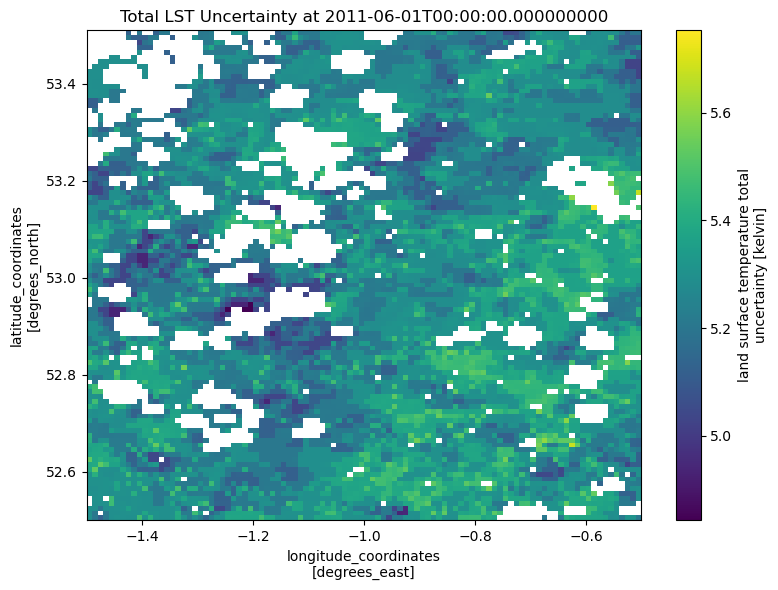

In [52]:
# Extract the total uncertainty variable
total_uncertainty = lst_example['lst_uncertainty']  # That's the total uncertainty

# Plot total uncertainty for a specific time step
time_step = total_uncertainty.time[5]  # Choose the sixth time step for June
plt.figure(figsize=(8, 6))
total_uncertainty.sel(time=time_step).plot(cmap="viridis")  # Xarray handles the colorbar
plt.title(f"Total LST Uncertainty at {time_step.values}")
plt.show()

### Step 2: Compare Uncertainty Components
To better understand the sources of uncertainty in the LST data, we visualize the spatial distribution of each component:
- Atmospheric Errors
- LST Correction Errors
- Surface Errors
- Random Errors

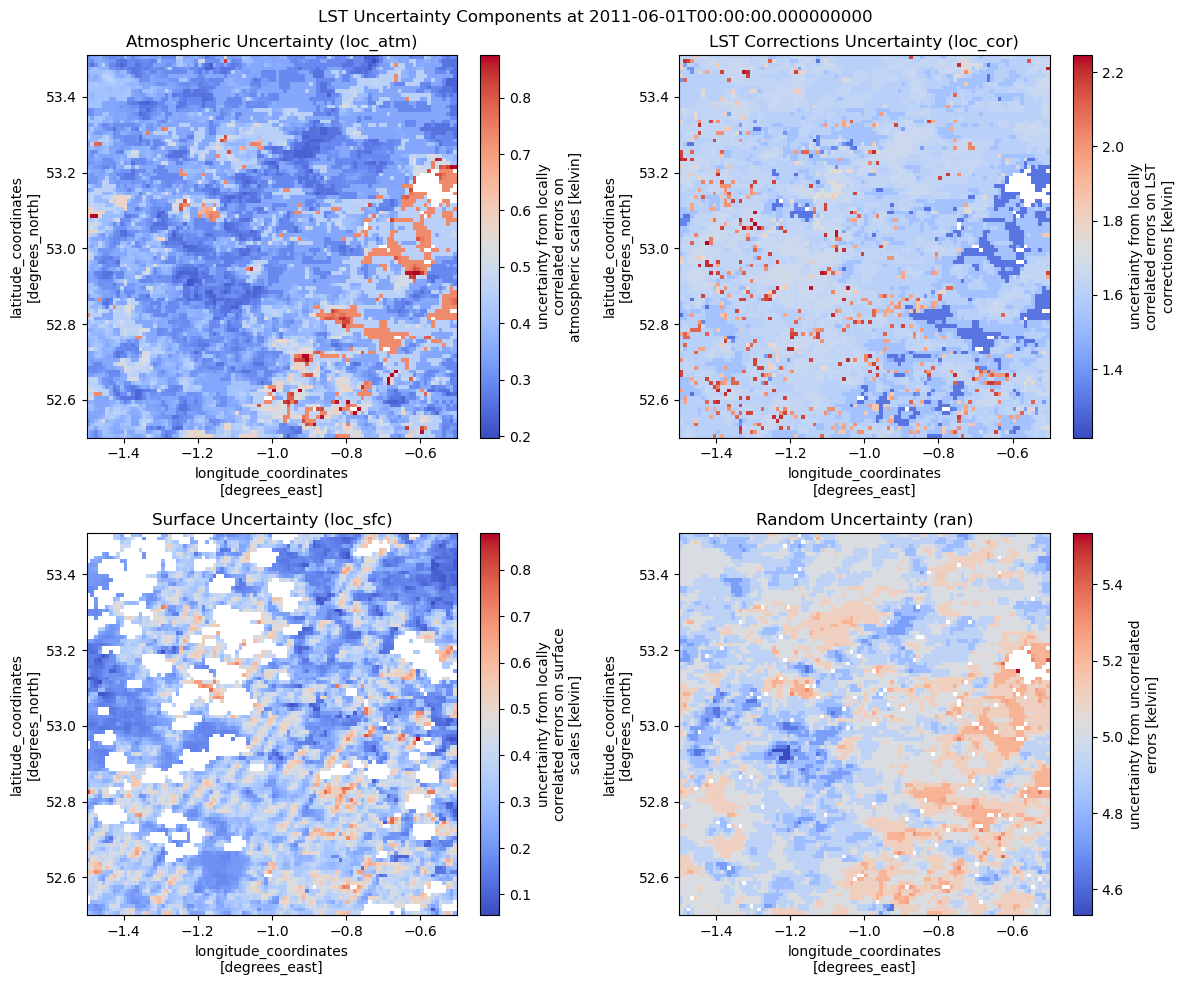

In [53]:
# Extract individual uncertainty components
unc_loc_atm = lst_example['lst_unc_loc_atm']
unc_loc_cor = lst_example['lst_unc_loc_cor']
unc_loc_sfc = lst_example['lst_unc_loc_sfc']
unc_ran = lst_example['lst_unc_ran']

# Plot individual components for a specific time step
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
components = [unc_loc_atm, unc_loc_cor, unc_loc_sfc, unc_ran]
titles = [
    "Atmospheric Uncertainty (loc_atm)",
    "LST Corrections Uncertainty (loc_cor)",
    "Surface Uncertainty (loc_sfc)",
    "Random Uncertainty (ran)"
]

for ax, comp, title in zip(axs.flat, components, titles):
    comp.sel(time=time_step).plot(ax=ax, cmap="coolwarm")
    ax.set_title(title)

plt.suptitle(f"LST Uncertainty Components at {time_step.values}")
plt.tight_layout()
plt.show()


### Step 3: Contribution to Total Uncertainty
Let's have a look at the contribution of each uncertainty component to the total uncertainty.

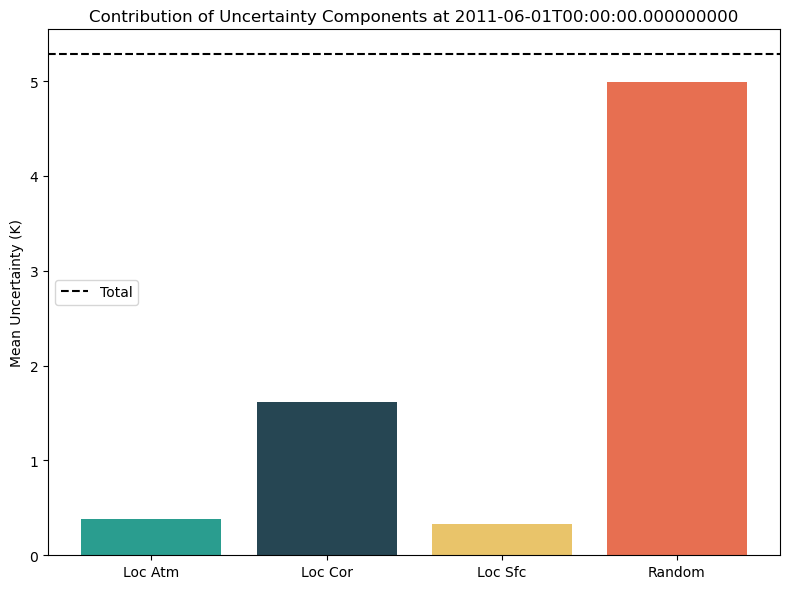

In [54]:
# Compute mean uncertainty components over the region and time
mean_unc_loc_atm = unc_loc_atm.mean(dim=["lat", "lon"]).sel(time=time_step)
mean_unc_loc_cor = unc_loc_cor.mean(dim=["lat", "lon"]).sel(time=time_step)
mean_unc_loc_sfc = unc_loc_sfc.mean(dim=["lat", "lon"]).sel(time=time_step)
mean_unc_ran = unc_ran.mean(dim=["lat", "lon"]).sel(time=time_step)
mean_total_unc = total_uncertainty.mean(dim=["lat", "lon"]).sel(time=time_step)

# Plot the contributions
contributions = [
    mean_unc_loc_atm, mean_unc_loc_cor, mean_unc_loc_sfc, mean_unc_ran
]
labels = ["Loc Atm", "Loc Cor", "Loc Sfc", "Random"]

plt.figure(figsize=(8, 6))
some_colors = ["#2a9d8f", "#264653", "#e9c46a", "#e76f51"]
plt.bar(labels, [c.values for c in contributions], color=some_colors)
plt.axhline(y=mean_total_unc.values, color="black", linestyle="--", label="Total")
plt.title(f"Contribution of Uncertainty Components at {time_step.values}")
plt.ylabel("Mean Uncertainty (K)")
plt.legend()
plt.show()


Random errors contribute the most to the total uncertainty in LST data because they arise from sensor noise, atmospheric variability, and surface heterogeneity, which are inherently unpredictable and uncorrelated across space and time. These errors are amplified in challenging conditions, such as areas with variable cloud cover, complex terrain, or mixed land cover types, where accurate retrieval of surface temperatures becomes more difficult. Additionally, the high-resolution nature of the data means more detailed measurements, which can increase the influence of random fluctuations compared to systematic or locally correlated errors.

### Step 4: Temporal Trends in Uncertainties
Here, we aim to identify how different sources of uncertainty in LST data vary over time. By examining temporal patterns, we hope to:
- Detect seasonal trends, such as higher uncertainties during periods of increased cloud cover or surface variability.
- Assess whether uncertainties remain stable over the dataset's time span or change due to factors like sensor transitions or calibration updates.
- Understand how each component contributes to the total uncertainty across different periods, which can provide insights into the consistency and reliability of the LST dataset for long-term climate studies.

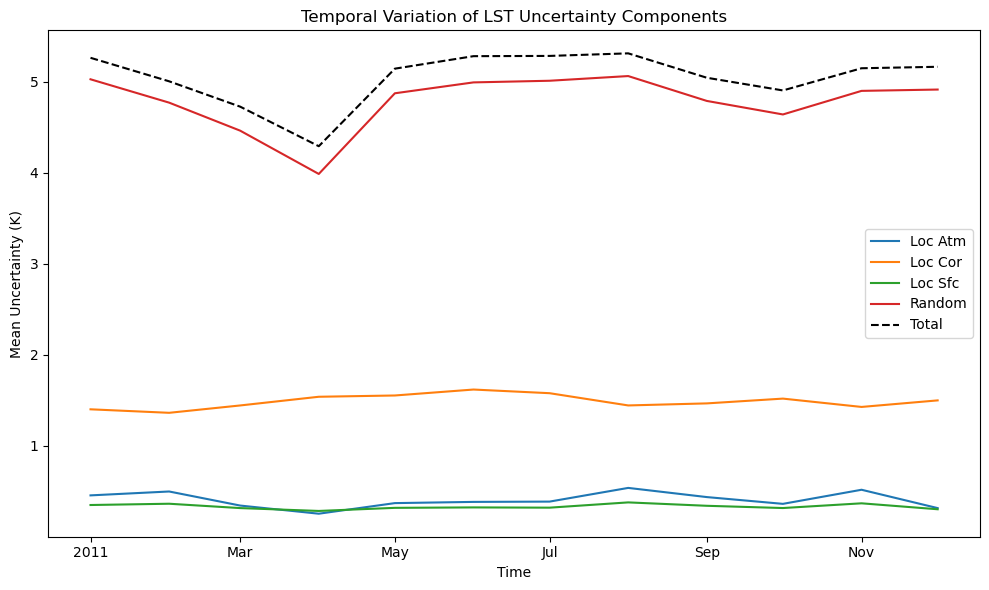

In [55]:
# Compute mean uncertainty components over time
mean_unc_loc_atm_time = unc_loc_atm.mean(dim=["lat", "lon"]).dropna(dim="time")
mean_unc_loc_cor_time = unc_loc_cor.mean(dim=["lat", "lon"]).dropna(dim="time")
mean_unc_loc_sfc_time = unc_loc_sfc.mean(dim=["lat", "lon"]).dropna(dim="time")
mean_unc_ran_time = unc_ran.mean(dim=["lat", "lon"]).dropna(dim="time")
mean_total_unc_time = total_uncertainty.mean(dim=["lat", "lon"]).dropna(dim="time")

# Plot the time series
plt.figure(figsize=(10, 6))
mean_unc_loc_atm_time.plot(label="Loc Atm")
mean_unc_loc_cor_time.plot(label="Loc Cor")
mean_unc_loc_sfc_time.plot(label="Loc Sfc")
mean_unc_ran_time.plot(label="Random")
mean_total_unc_time.plot(label="Total", linestyle="--", color="black")
plt.title("Temporal Variation of LST Uncertainty Components")
plt.ylabel("Mean Uncertainty (K)")
plt.xlabel("Time")
plt.legend()
plt.show()